# W43 Wavelet analysis

Test of the wavelet analysis technique on the Herschel $l=30^{\circ}$ field.

In [1]:
import aplpy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


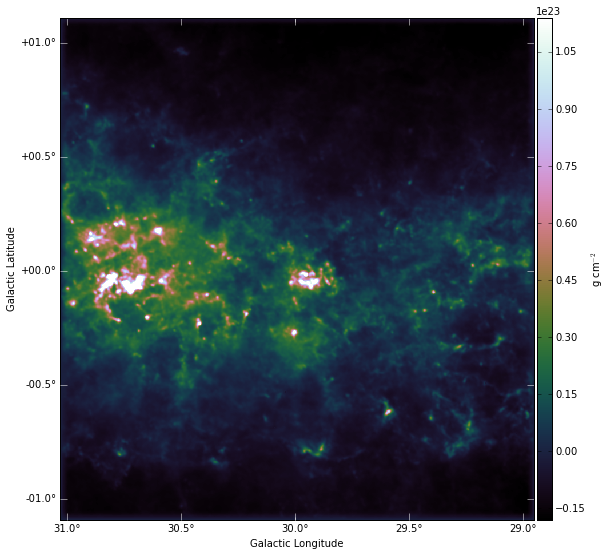

In [2]:
#W43 density map where the nan have been removed, the mean map value
#subtracted, and edges apodized to mini the "step function effect"
#in the Fourier and wavelet transform.

figfile = '/Users/jfrob/postdoc/Herschel/W43_density_galcut_nan_apod.fits'
fig = aplpy.FITSFigure(figfile, convention='calabretta')
fig.show_colorscale(vmin=-1.8e22,vmax=1.14e23,cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_minor_frequency(0.1,0.1)
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'g cm$^{-2}$')

Calculate the Fourier and wavelet power spectra

In [3]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
output_notebook()

from astropy.io import fits
from powspec import powspec
from wavan import fan_trans

Loading BokehJS ...

In [4]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data

In [ ]:
#Reduce dynamical range (Doesn't change the result)
#im = im / 1.0e22

#Fourier power spectrum
tab_k, spec_k = powspec(im, reso=1)

#Plot Fourier power spectrum
f = figbok( x_axis_label="Wavenumber k", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log")
f.line(tab_k, spec_k, legend='Fourier')

#Set a list of q
q = [2.0]*25

#Wavelet power spectrum
wt, wav_k, S1a = fan_trans(im, reso=1, q=q)

f.diamond(wav_k, S1a[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1a[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1a[2,:], legend='Gaussian',color='red',line_width=5)

showbok(f)

Reconstruct Segmented Structures

M =  23


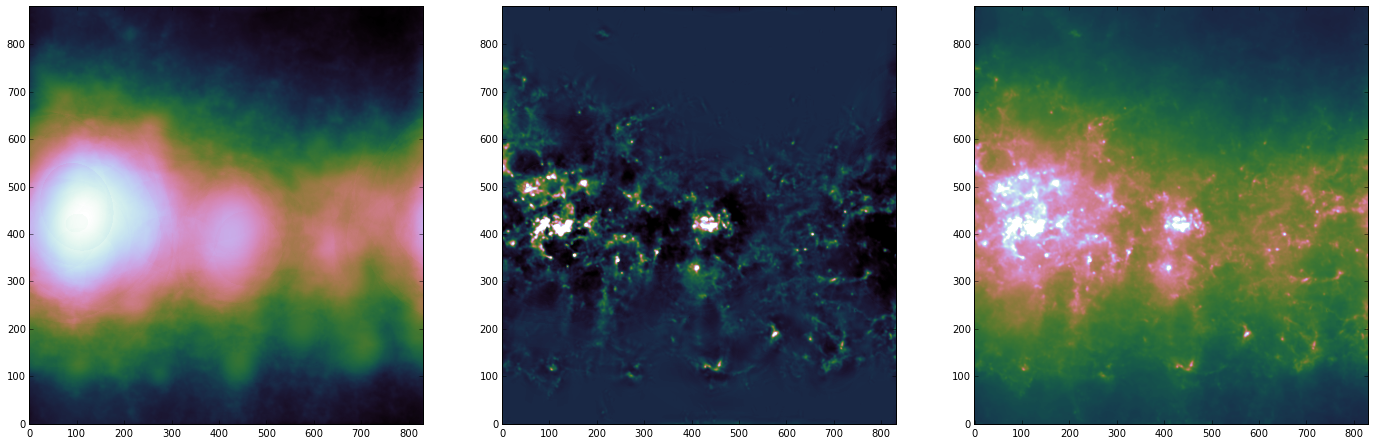

In [16]:
M = np.shape(wav_k)[0]
print 'M = ', M

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

#fits.writeto('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_galcut_nan_cohe.fits',\
#            coherent.real,HDU[0].header)
#fits.writeto('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_galcut_nan_gaussian.fits',\
#            Gaussian.real,HDU[0].header)

plt.figure(figsize=(24,8))

plt.subplot(131)
plt.imshow(Gaussian.real,origin='below',cmap='cubehelix')
plt.subplot(132)
plt.imshow(coherent.real,origin='below',cmap='cubehelix',vmin=-2,vmax=11)
plt.subplot(133)
plt.imshow(Gaussian.real+coherent.real,origin='below',cmap='cubehelix',vmin=1.5,vmax=25)

It can be seen in the wavelet power spectra that most of the power is associated with the coherent features. This is probably caused by intense point sources which behaves like Diract functions and thus add power at many spatial frequencies.

It is interesting to note that (Gaussian + Coherent) do not failed to reconstruct the initial image. As in the case of the Fourier transform of a signal with Diract functions or discontinuities, its Fourier power spectrum will be affected, but the inverse Fourier transform will also allow one to recover the signal exactly.

However, for our analysis, we need the sources to appear only at small scales.

Is the application of a simple threshold could solve the proplem?

Test the transforms on a new image with a threshold of $1.5\times10^{23}$

In [5]:
imthres = im.copy()
imthres[im > 1.5e23] = 1.5e23

sig = imthres[414,:]
x = range(np.shape(im)[1])

Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Pixels", y_axis_label="Values", tools=Tools)
f.line(x,sig, legend='Fourier')

showbok(f)

In [7]:
#Fourier power spectrum
tab_k, spec_k = powspec(imthres, reso=1)

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Wavenumber k", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_k, legend='Fourier')

#Set a list of q
q = [2.5]*25

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(imthres, reso=1, q=q, qdyn=True)

f.diamond(wav_k, S1a[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1a[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1a[2,:], legend='Gaussian',color='red',line_width=5)

showbok(f)

In [8]:
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_wt.npy',wt)
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_S11a.npy',S11a)
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_wav_k.npy',wav_k)
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_S1a.npy',S1a)
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_q.npy',q)

<matplotlib.colorbar.Colorbar instance at 0x1224e4320>

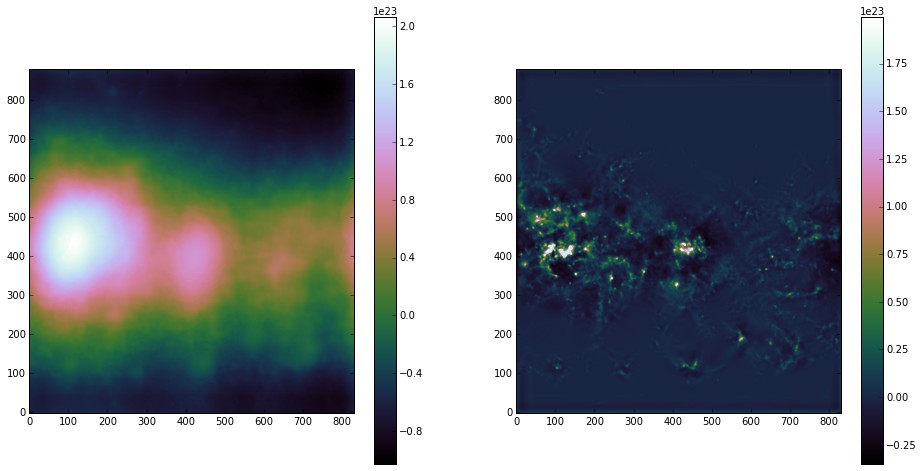

In [14]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)+np.sum(wt[0:6,:,:],axis=0)

fits.writeto('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_galcut_nan_cohe.fits',\
            coherent.real,HDU[0].header,overwrite=True)
fits.writeto('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_galcut_nan_gaussian.fits',\
            Gaussian.real,HDU[0].header,overwrite=True)

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.imshow(Gaussian.real,origin='below',cmap='cubehelix')
plt.colorbar()
plt.subplot(122)
plt.imshow(coherent.real,origin='below',cmap='cubehelix')
plt.colorbar()

In [26]:
import seaborn as sns
sns.set(color_codes=True)

In [27]:
plt.figure(figsize=(7,7))
sns.distplot(im.reshape(im.shape[0]*im.shape[1]),bins=250)
plt.xlim([0,20])
sns.reset_orig()

AttributeError: 'AxesImage' object has no attribute 'reshape'

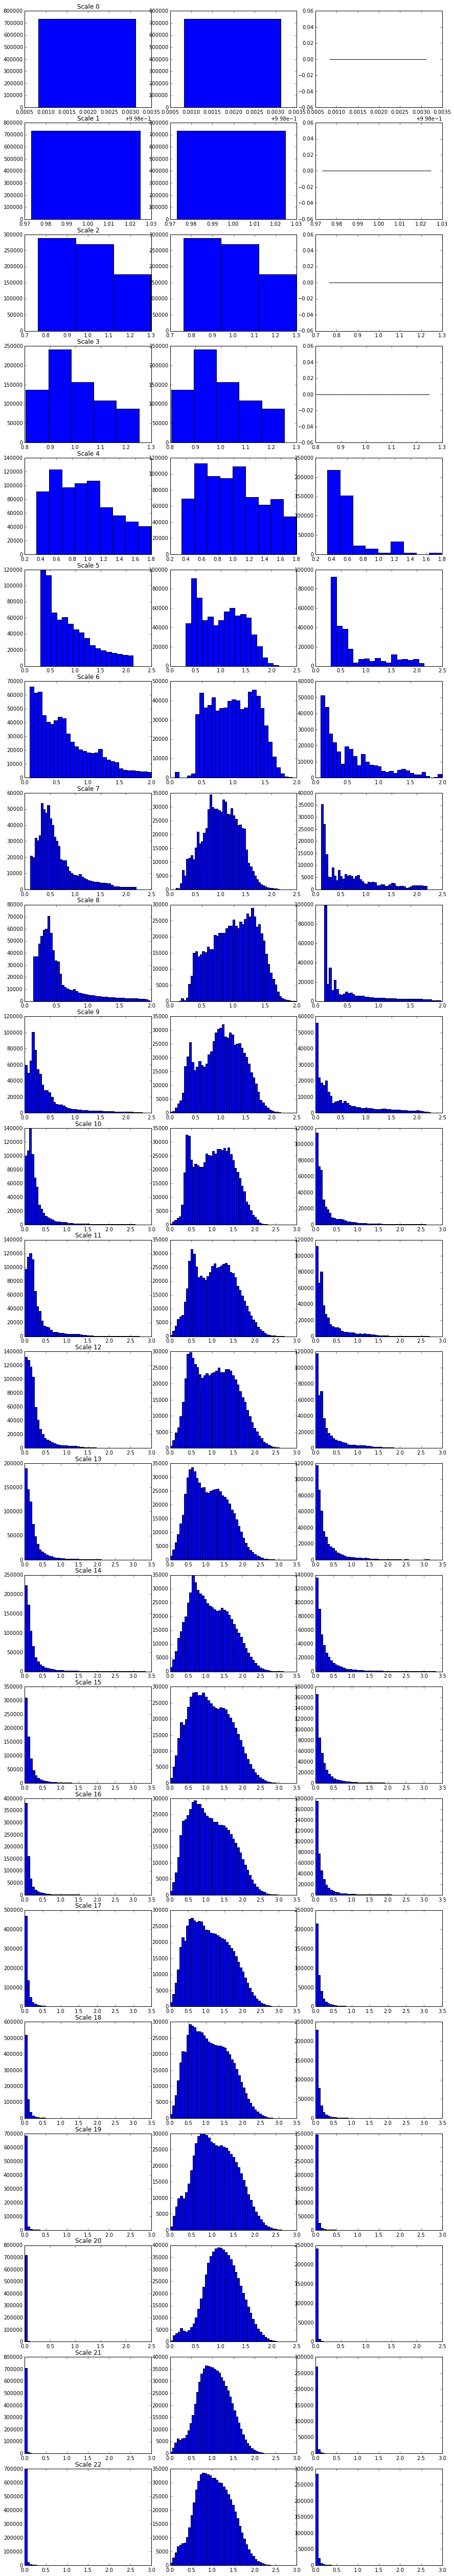

In [15]:
fig, axs = plt.subplots(M,3,figsize=(12,70))

axs = axs.ravel()
fig.tight_layout()

for i in range(M):
    
    if np.mean(S11a[M+i,:,:]) !=0:
        wc = (S11a[M+i,:,:])/np.mean(S11a[M+i,:,:])
    else:
        wc = np.zeros((im.shape[0],im.shape[1]))
    wo = (S11a[i,:,:])/np.mean(S11a[i,:,:])
    #wg = (S11a[2*M+i,0:100 & 700:,:])/np.mean(S11a[2*M+i,:,:])
    #wg = (S11a[2*M+i,100:700,:])/np.mean(S11a[2*M+i,:,:])
    wg = (S11a[2*M+i,:,:])/np.mean(S11a[2*M+i,:,:])
    
    #Number of independent points
    npix = np.int((imthres.shape[0] * wav_k[i])**2.)
    if npix == 0: nbins=1
    if npix > 0 & npix < 50 : nbins=npix
    if npix > 50 : nbins=50
    
    histo, edges = np.histogram(wo,bins=nbins)
    histo_c, edges = np.histogram(wc[wc != 0.],bins=nbins)
    histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)
    
    axs[i*3].bar(edges[:-1], histo, width=np.diff(edges), align="edge")
    axs[i*3].set_title('Scale '+np.str(i))
    
    axs[i*3+1].bar(edges[:-1], histo_g, width=np.diff(edges), align="edge")
    
    axs[i*3+2].bar(edges[:-1], histo_c, width=np.diff(edges), align="edge")

The Gaussian part is clearly bimodal (there is even perhaps three modes at small scales starting from Scale 19).

The similarity between the distribution of all coefficients (left row) and the non-Gaussian part is stricking. As an attempt to apply the same extraction algorithm on the non-Gaussian coefficients only, the fan_transform function will be applied a second time on the non-Gaussian coefficients only.

It is important to note that since the reconstruction from the Morlet wavelet coefficients is not perfect, some errors will propagate through this second transform and segmentation algorithm.

In [ ]:
#Fourier power spectrum
tab_k, spec_k = powspec(coherent.real, reso=1)

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Wavenumber k", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_k, legend='Fourier')

#Constant q
qc = [2.5]*25

#Set limit based on the noise level of the original power spectrum,
#so that PDFs are analysed for bins that are only above the noise
limit = np.sqrt(S1a[0,21]*wav_k[21]**2.)

#Wavelet power spectrum
wtc, S11ac, wav_kc, S1ac, qc = fan_trans(coherent.real, reso=1,\
                                    q=qc, limit=limit, qdyn=True)

f.diamond(wav_kc, S1ac[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_kc, S1ac[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_kc, S1ac[2,:], legend='Gaussian',color='red',line_width=5)

showbok(f)

In [8]:
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_wtc.npy',wtc)
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_S11ac.npy',S11ac)
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_wav_kc.npy',wav_kc)
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_S1ac.npy',S1ac)
np.save('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_qc.npy',qc)

<matplotlib.colorbar.Colorbar instance at 0x11a236368>

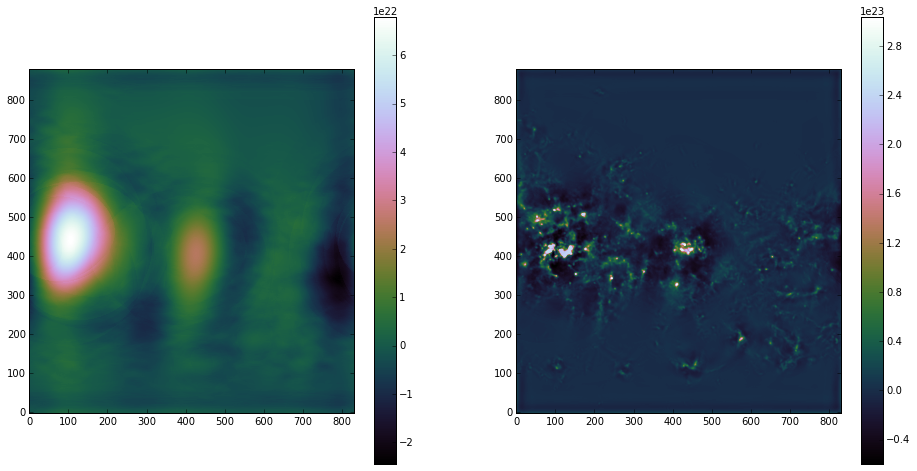

In [13]:
Mc = wav_kc.shape[0]

sqcoherent = np.sum(wt[M:2*M,:,:],axis=0)
sqGaussian = np.sum(wt[2*M:3*M,:,:],axis=0)+np.sum(wt[0:6,:,:],axis=0)

#fits.writeto('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_galcut_nan_cohe.fits',\
#            sqcoherent.real,HDU[0].header,overwrite=True)
#fits.writeto('/Users/jfrob/postdoc/fil2star/segmentation/Herschel/W43_density_galcut_nan_gaussian.fits',\
#            sqGaussian.real,HDU[0].header,overwrite=True)

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.imshow(sqGaussian.real,origin='below',cmap='cubehelix')
plt.colorbar()
plt.subplot(122)
plt.imshow(sqcoherent.real,origin='below',cmap='cubehelix')
plt.colorbar()

Plot the segmented non-Gaussian wavelet coefficients PDFs

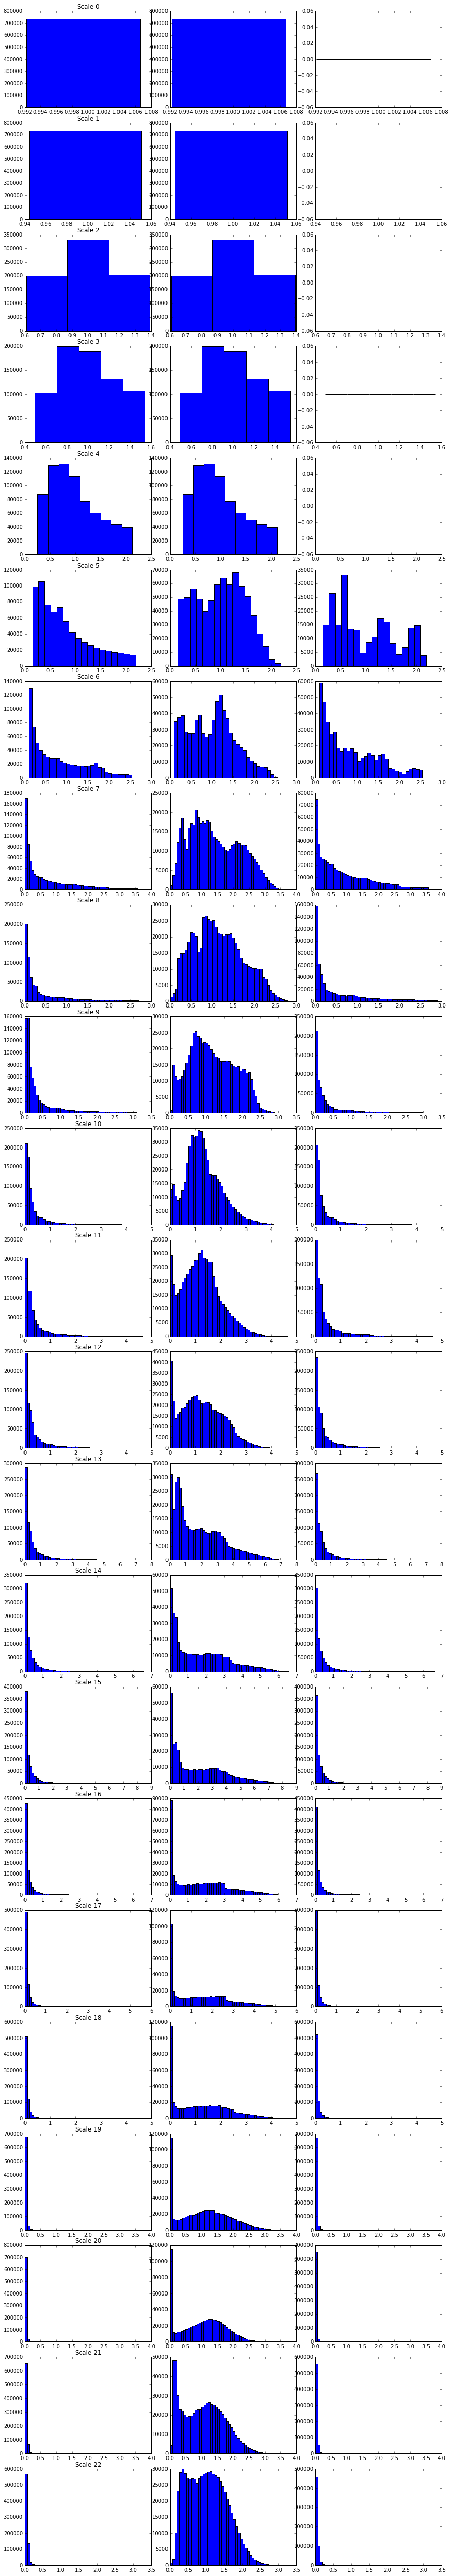

In [14]:
fig, axs = plt.subplots(M,3,figsize=(12,70))

axs = axs.ravel()
fig.tight_layout()

for i in range(M):
    
    if np.mean(S11a[M+i,:,:]) !=0:
        wc = (S11a[M+i,:,:])/np.mean(S11a[M+i,:,:])
    else:
        wc = np.zeros((im.shape[0],im.shape[1]))
    wo = (S11a[i,:,:])/np.mean(S11a[i,:,:])
    #wg = (S11a[2*M+i,0:100 & 700:,:])/np.mean(S11a[2*M+i,:,:])
    #wg = (S11a[2*M+i,100:700,:])/np.mean(S11a[2*M+i,:,:])
    wg = (S11a[2*M+i,:,:])/np.mean(S11a[2*M+i,:,:])
    
    #Number of independent points
    npix = np.int((imthres.shape[0] * wav_k[i])**2.)
    if npix == 0: nbins=1
    if npix > 0 & npix < 50 : nbins=npix
    if npix > 50 : nbins=50
    
    histo, edges = np.histogram(wo,bins=nbins)
    histo_c, edges = np.histogram(wc[wc != 0.],bins=nbins)
    histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)
    
    axs[i*3].bar(edges[:-1], histo, width=np.diff(edges), align="edge")
    axs[i*3].set_title('Scale '+np.str(i))
    
    axs[i*3+1].bar(edges[:-1], histo_g, width=np.diff(edges), align="edge")
    
    axs[i*3+2].bar(edges[:-1], histo_c, width=np.diff(edges), align="edge")

In [ ]:
print q

x = range(25)
plot(x,np.array(q).reshape(25))

Could we measure the skewness of Gaussian distributions and choose to set a lower q parameter if the skewness is too high?

<Container object of 50 artists>

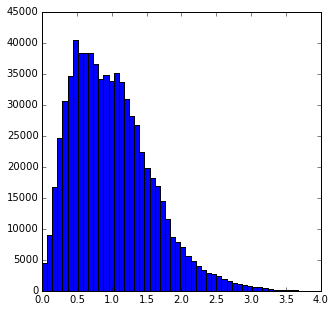

In [107]:
#Example of a "symmetrical" distribution
i=8
wg = abs(wt[2*M+i,:,:])/np.mean(abs(wt[2*M+i,:,:]))

plt.figure(figsize(5,5))
histo_g, edges = np.histogram(wg,bins=50)
plt.bar(edges[:-1], histo_g, width=np.diff(edges), align="edge")

In [6]:
from scipy.stats import skew

In [17]:
print 'Skewness =', skew(wg.reshape(wg.shape[0]*wg.shape[1]))

Skewness = 1.16006775483


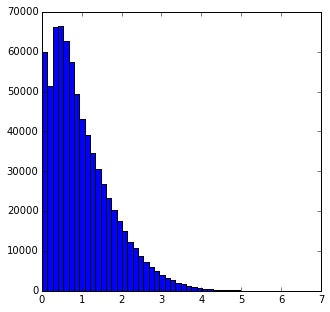

In [124]:
#Example of an "asymmetrical" distribution
i=16
wg = abs(wt[2*M+i,:,:])/np.mean(abs(wt[2*M+i,:,:]))

plt.figure(figsize(5,5))
histo_g, edges = np.histogram(wg,bins=50)
plt.bar(edges[:-1], histo_g, width=np.diff(edges), align="edge")

print 'Skewness =', skew(wg.reshape(wg.shape[0]*wg.shape[1]))

What is the skewness of a Ricean distribution?

$R\sim \mathrm{Rice} \left(|\nu |,\sigma \right)$ has a Rice distribution if $R={\sqrt {X^{2}+Y^{2}}}$ where $X\sim N\left(\nu \cos \phi ,\sigma ^{2}\right)$ and $Y\sim N\left(\nu \sin \phi ,\sigma ^{2}\right)$ are statistically independent normal random variables and $\phi$ is any real number (Wikipedia).

A Gaussian random field, or fractional Brownian motion (fBm), is created in a Fourier space by assigning a power law to the squared amplitude distribution, $P(k) \simeq |A(k)|^{2} \simeq k^{-\alpha}$, and a random phase distribution across the uv-plane. The real ($\Re$) and imaginary ($\Im$) part of the Fourier transform of the image is then calculated following the relations:

$$\Re = A * \cos \phi$$
$$\Im = A * \sin \phi,$$

where the amplitude can be retrieve with:

$$A={\sqrt {\Re^{2}+\Im^{2}}},$$

which is the Ricean distribution definition.

Skewness = 0.621448031378


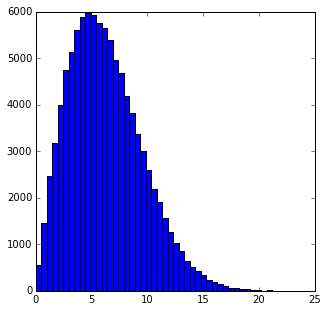

In [14]:
data1 = np.random.normal(0,5, 100000)
data2 = np.random.normal(0,5, 100000)

rice = np.sqrt(data1**2. + data2**2.)
plt.figure(figsize(5,5))
histo, edges = np.histogram(rice,bins=50)
plt.bar(edges[:-1], histo, width=np.diff(edges), align="edge")

print 'Skewness =', skew(rice)